# Matchup satellite data to ship, glider, or animal tracks

## Overview
> History | Updated July 2024  

In this exercise you will extract satellite data around a set of points defined by longitude, latitude, and time coordinates, like that produced by an animal telemetry tag, and ship track, or a glider tract.

Please note that there may be more efficient ways, more Pythonic ways, to accomplish the tasks in this tutorial. The tutorial was developed to be easier to follow for less experienced users of Python.

### The exercise demonstrates the following techniques:

* Loading data from a tab- or comma-separated file
* Plotting the latitude/longitude points onto a map 
* Extracting satellite data along a track
* Saving results as a CSV file
* Plotting the satellite data onto a map  

### Datasets used:
- Chlorophyll a concentration from the European Space Agency's Ocean Colour Climate Change Initiative Monthly dataset v6.0
- Yellowfin tuna telemetry track data that was developed as part of the Palmyra Bluewater Research (PBR) project (https://portal.atn.ioos.us/?ls=861Wqpd2#metadata/1f877c4c-7b50-49f5-be86-3354664e0cff/project). This example track used in the tutorial is from May 2022 to November 2022 and accessed via the Animal Telemetry Network (ATN) data portal.

### Python packages used:
- pandas (reading and analyzing data)  
- numpy  (data analysis, manipulation)
- xarray (multi-dimensional data analysis, manipulation)
- matplotlib (mapping)
- cartopy (mapping)
- datetime (date manipulation)

## Import the required Python modules

In [1]:
from IPython.display import clear_output
import pandas as pd
import numpy as np
import os
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import xarray as xr
warnings.filterwarnings('ignore')

## Load the track data into a Pandas data frame
Below, the track data will load using the Pandas "read_csv" method. 
* Then use the ".head()" method to view the column names and the first few rows of data. 


In [3]:
track_path

'../data/THUALB_2022_04-233568-5-GPE3.csv'

In [95]:
track_path = os.path.join('..',
                          'data',
                          'THUALB_2022_04-233568-5-GPE3.csv')

df = pd.read_csv(track_path, skiprows=4)
print(df.head(2))

         DeployID     Ptt                  Date  Most Likely Latitude  \
0  THUALB_2022_04  233568  31-May-2022 19:00:00                 5.875   
1  THUALB_2022_04  233568  01-Jun-2022 00:00:00                 5.875   

   Most Likely Longitude Observation Type  Observed SST  Satellite SST  \
0               -162.125             User           NaN            NaN   
1               -162.100             None           NaN            NaN   

   Observed Depth  Bathymetry Depth  Observation LL (MSS)  Observation Score  \
0             NaN               NaN                   NaN          68.605853   
1             NaN               NaN                   NaN                NaN   

                Sunrise                Sunset  
0                   NaN                   NaN  
1  01-Jun-2022 16:33:04  02-Jun-2022 04:59:36  


In [14]:
# Convert lontitudes to 0~360 (Re-center map to the dateline)
df['Most Likely Longitude'] = df['Most Likely Longitude']+360
print(df.head(2))

         DeployID     Ptt                  Date  Most Likely Latitude  \
0  THUALB_2022_04  233568  31-May-2022 19:00:00                 5.875   
1  THUALB_2022_04  233568  01-Jun-2022 00:00:00                 5.875   

   Most Likely Longitude Observation Type  Observed SST  Satellite SST  \
0                197.875             User           NaN            NaN   
1                197.900             None           NaN            NaN   

   Observed Depth  Bathymetry Depth  Observation LL (MSS)  Observation Score  \
0             NaN               NaN                   NaN          68.605853   
1             NaN               NaN                   NaN                NaN   

                Sunrise                Sunset  
0                   NaN                   NaN  
1  01-Jun-2022 16:33:04  02-Jun-2022 04:59:36  


In [22]:
df.iloc[:,4]

0      197.875
1      197.900
2      198.025
3      198.025
4      198.025
        ...   
832    198.150
833    198.175
834    198.225
835    198.325
836    198.350
Name: Most Likely Longitude, Length: 837, dtype: float64

## Plot the track on a map

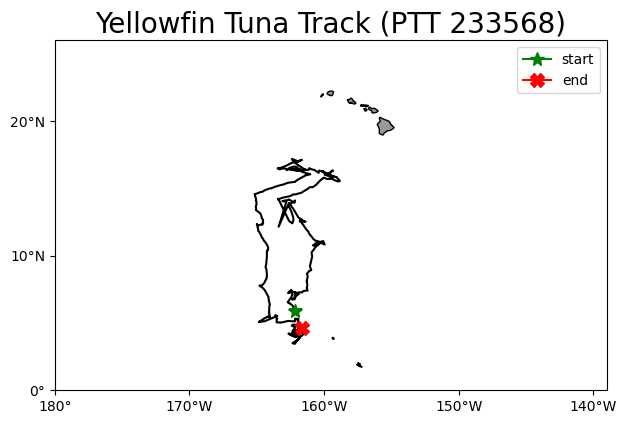

In [30]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([180, 221, 0, 26], ccrs.PlateCarree())

# Set the tick marks to be slightly inside the map extents
ax1.set_xticks(range(180, 221, 10), crs=ccrs.PlateCarree())
ax1.set_yticks(range(0, 26, 10), crs=ccrs.PlateCarree())

# Add feature to the map
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# Format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# Bring the lon and lat data into a numpy array 
x, y = df["Most Likely Longitude"].to_numpy(), df["Most Likely Latitude"].to_numpy()
ax1 = plt.plot(x, y, transform=ccrs.PlateCarree(), color='k')
# start point in green star
ax1 = plt.plot(x[0], y[0],
               marker='*',
               color='g',
               label='start',
               transform=ccrs.PlateCarree(),
               markersize=10)
# end point in red X
ax1 = plt.plot(x[-1], y[-1],
               marker='X',
               color='r',
               label='end',
               transform=ccrs.PlateCarree(),
               markersize=10)
plt.legend()
plt.title('Yellowfin Tuna Track (PTT 233568)', fontsize=20)

plt.show()

## Prepare track data for use to extract satellite data

### Create a column with Pandas date objects  

__We will use the ".str.split()" and "str[]" functions to extract the date information from the original "Date" column, and use the "pd.to_datetime" function to create a new column with the desired format (numerical and in the order of "year-month-day"). We then add the new column "year-month-day" to the original dataframe.__   


In [97]:
new_date_df = pd.to_datetime(df["Date"].str.split().str[0])
print(new_date_df.head(2))

0   2022-05-31
1   2022-06-01
Name: Date, dtype: datetime64[ns]


In [98]:
df["year-month-day"]= new_date_df
print(df.head(2))

         DeployID     Ptt                  Date  Most Likely Latitude  \
0  THUALB_2022_04  233568  31-May-2022 19:00:00                 5.875   
1  THUALB_2022_04  233568  01-Jun-2022 00:00:00                 5.875   

   Most Likely Longitude Observation Type  Observed SST  Satellite SST  \
0               -162.125             User           NaN            NaN   
1               -162.100             None           NaN            NaN   

   Observed Depth  Bathymetry Depth  Observation LL (MSS)  Observation Score  \
0             NaN               NaN                   NaN          68.605853   
1             NaN               NaN                   NaN                NaN   

                Sunrise                Sunset year-month-day  
0                   NaN                   NaN     2022-05-31  
1  01-Jun-2022 16:33:04  02-Jun-2022 04:59:36     2022-06-01  


## Extract data from a satellite dataset corresponding to points on the track

We are going to download data from an ERDDAP server using the following steps: 
* Select a dataset on an ERDDAP server
* Open the dataset using the Xarray module
* Loop though the track data and pull out the date, latitude and longitude coordinates from each row 
* Insert these coordinates into the Xarray open-dataset object to select and download the satellite data that corresponds to the coordinates. 
* Store the satellite data in a temporary Pandas data frame
* Once all the satellite data has been added to the temporary data frame, merge it with the track data frame.

### Select a dataset

We'll use the European Space Agency's OC-CCI product (https://climate.esa.int/en/projects/ocean-colour/) to obtain chlorophyll data. This is a merged product that blends data from many ocean color sensors to create a long time series (1997-present) with better spatial coverage than any single sensor.


Ideally we would use a daily dataset, selecting the day that corresponds to the track data date. However, chlorophyll measurements can have a lot of missing data, primarily due to cloud cover. To reduce data gaps and improve the likelihood of data for our matchups, we can use a dataset that combines all of the data from each month into the monthly average. 

__The ERDDAP URL to the monthly version of the OC-CCI product is below:__    
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0  
 


###  Open the satellite data in Xarray
* Use the ERDDAP URL with no extension (e.g. without .html or .graph...). This is the OPeNDAP URL, which allows viewing  the dataset metadata and, when you select the data you want, downloading the data.
* Use the Xarray "open_dataset" function then view the metadata

In [85]:
erddap_url = '/'.join(['https://oceanwatch.pifsc.noaa.gov',
                       'erddap',
                       'griddap',
                       'esa-cci-chla-monthly-v6-0'])

ds = xr.open_dataset(erddap_url)
ds

<xarray.Dataset>
Dimensions:             (time: 316, latitude: 4320, longitude: 8640)
Coordinates:
  * time                (time) datetime64[ns] 1997-09-04 ... 2023-12-01
  * latitude            (latitude) float64 89.98 89.94 89.9 ... -89.94 -89.98
  * longitude           (longitude) float64 0.02083 0.0625 ... 359.9 360.0
Data variables:
    chlor_a             (time, latitude, longitude) float32 ...
    MERIS_nobs_sum      (time, latitude, longitude) float32 ...
    MODISA_nobs_sum     (time, latitude, longitude) float32 ...
    OLCI_A_nobs_sum     (time, latitude, longitude) float32 ...
    OLCI_B_nobs_sum     (time, latitude, longitude) float32 ...
    SeaWiFS_nobs_sum    (time, latitude, longitude) float32 ...
    VIIRS_nobs_sum      (time, latitude, longitude) float32 ...
    chlor_a_log10_bias  (time, latitude, longitude) float32 ...
    chlor_a_log10_rmsd  (time, latitude, longitude) float32 ...
    total_nobs_sum      (time, latitude, longitude) float32 ...
Attributes: (12/53)
    cdm_data_type:                     Grid
    comment:                           See summary attribute
    Conventions:                       CF-1.7, COARDS, ACDD-1.3
    creation_date:                     Thu Jan 18 09:04:18 2024
    creator_email:                     help@esa-oceancolour-cci.org
    creator_name:                      Plymouth Marine Laboratory
    ...                                ...
    time_coverage_end:                 2023-12-01T00:00:00Z
    time_coverage_resolution:          P1M
    time_coverage_start:               1997-09-04T00:00:00Z
    title:                             Chlorophyll a concentration, ESA OC CC...
    tracking_id:                       abd52a4c-7009-464f-b1eb-958f7d333a1d
    Westernmost_Easting:               0.020833333333314386

__Opening the dataset in Xarray lets you look at the dataset metadata.__   
* The metadata are listed above.
* No data is downloaded until you request it.  

__From the metadata you can view:__ 
* The coordinates (time, latitude and longitude) that you will use to select the data to download.
* A list of ten data variables. For this exercise, we want the "chlor_a" variable. If you want, you can find out about each variable with clicking the page icon to the right of each variable name. 


__A note on dataset selection__  
We have preselected the OC-CCI monthly dataset because we know it will work with this exercise. If you were selecting datasets on your own, you would want to check out the dataset to determine if its spatial and temporal coverages are suitable for your application. 

You can find that information above by clicking the right arrow next to "Attribute". Then look through the list to find: 
* 'time_coverage_start' and 'time_coverage_end': the time range
* 'geospatial_lat_min' and 'geospatial_lat_max': the latitude range
* 'geospatial_lon_min' and 'geospatial_lon_max': the longitude range

There are a lot of metadata attributes to look through. We can make it easier with a little code to print out the metadata of interest. Then compare these ranges to those found in your track data.


In [99]:
print('Temporal and spatial ranges of the satellite dataset')
print('time range', ds.attrs['time_coverage_start'], 
      ds.attrs['time_coverage_end'])
print('latitude range', ds.attrs['geospatial_lat_min'], 
      ds.attrs['geospatial_lat_max'])
print('longitude range', ds.attrs['geospatial_lon_min'], 
      ds.attrs['geospatial_lon_max'])
print(' ')
print('Temporal and spatial ranges of the track data')
print('time range', df["year-month-day"].min(), df["year-month-day"].max())
print('latitude range', 
      round(df["Most Likely Latitude"].min(), 2), round(df["Most Likely Latitude"].max(), 2))
print('longitude range', 
      round(df["Most Likely Longitude"].min(), 2), round(df["Most Likely Longitude"].max(), 2))

Temporal and spatial ranges of the satellite dataset
time range 1997-09-04T00:00:00Z 2023-12-01T00:00:00Z
latitude range -89.97916666666666 89.97916666666667
longitude range 0.020833333333314386 359.97916666666663
 
Temporal and spatial ranges of the track data
time range 2022-05-31 00:00:00 2022-11-23 00:00:00
latitude range 3.45 17.18
longitude range -165.15 -158.82


### Download the satellite data that corresponds to each track location

In [100]:
# Create a temporary Pandas data frame to hold the downloaded satellite data
col_names = ["erddap_date", "matched_lat", "matched_lon", "matched_chla"]
tot = pd.DataFrame(columns=col_names)

# Finish each URL and download
for i in range(0, len(df)):
    clear_output(wait=True)
    print(i+1, 'of', len(df))
    
    # Crop the dataset to include data that corresponds to track locations
    cropped_ds = ds['chlor_a'].sel(time=df["year-month-day"][i],
                                   latitude=df["Most Likely Latitude"][i],
                                   longitude=df["Most Likely Longitude"][i],
                                   method='nearest'
                                   )
     
    # Downloaded the data and add it to a new line in the tot data frame
    tot.loc[len(tot.index)] = [cropped_ds.time.values,
                               np.round(cropped_ds.latitude.values, 5),  # round 5 dec
                               np.round(cropped_ds.longitude.values, 5), # round 5 dec
                               np.round(cropped_ds.values, 2)  # round 2 decimals
                               ]
    
    print(tot.loc[[len(tot)-1]])

tot.head(2)

837 of 837
    erddap_date  matched_lat  matched_lon  matched_chla
836  2022-12-01      4.60417      0.02083           0.3


,erddap_date,matched_lat,matched_lon,matched_chla
0,2022-06-01,5.85417,0.02083,NaN
1,2022-06-01,5.85417,0.02083,NaN


### Consolidate the downloaded satellite data into the track data frame

In [101]:

df[['matched_lat', 
    'matched_lon', 
    'matched_chla', 
    'erddap_date']] = tot[['matched_lat',
                           'matched_lon',
                           'matched_chla',
                           'erddap_date']]

df.head(2)

,DeployID,Ptt,Date,Most Likely Latitude,Most Likely Longitude,Observation Type,Observed SST,Satellite SST,Observed Depth,Bathymetry Depth,Observation LL (MSS),Observation Score,Sunrise,Sunset,year-month-day,matched_lat,matched_lon,matched_chla,erddap_date
0,THUALB_2022_04,233568,31-May-2022 19:00:00,5.875,-162.125,User,NaN,NaN,NaN,NaN,NaN,68.605853,NaN,NaN,2022-05-31,5.85417,0.02083,NaN,2022-06-01
1,THUALB_2022_04,233568,01-Jun-2022 00:00:00,5.875,-162.100,None,NaN,NaN,NaN,NaN,NaN,NaN,01-Jun-2022 16:33:04,02-Jun-2022 04:59:36,2022-06-01,5.85417,0.02083,NaN,2022-06-01


### Save your work

In [102]:
df.to_csv('chl_matchup_tuna233568.csv', index=False, encoding='utf-8')

## Plot chlorophyll matchup data onto a map

### First plot a histogram of the chlorophyll data

Range: 0.11999999731779099 9.869999885559082


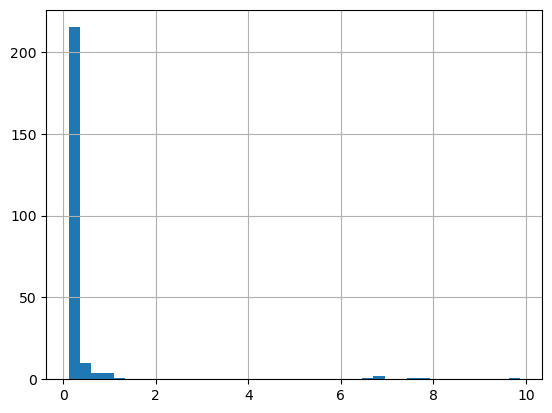

In [103]:
print('Range:', df.matched_chla.min(), df.matched_chla.max())
_ = df.matched_chla.hist(bins=40)

The range of chlorophyll values can be large, with lots of very low values and a few very high values. Using a  linear color bar,  most of the lower values would have the same color.
* To better visualize the data, we often plot the log or log10 of chlorophyll. 

### Plot a histogram of the log of the chlorophyll data

Range: -2.1202635585518332 2.2894998418505654


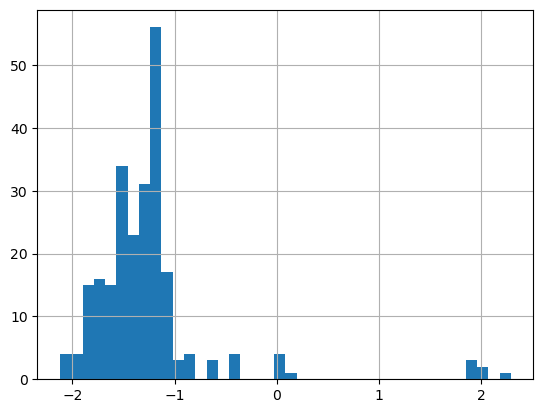

In [104]:
print('Range:', np.log(df.matched_chla.min()), np.log(df.matched_chla.max()))
_ = np.log(df.matched_chla).hist(bins=40)

* The logarithmic transformation displays the range of values across the color bar range (above). 

### Map the chlorophyll data

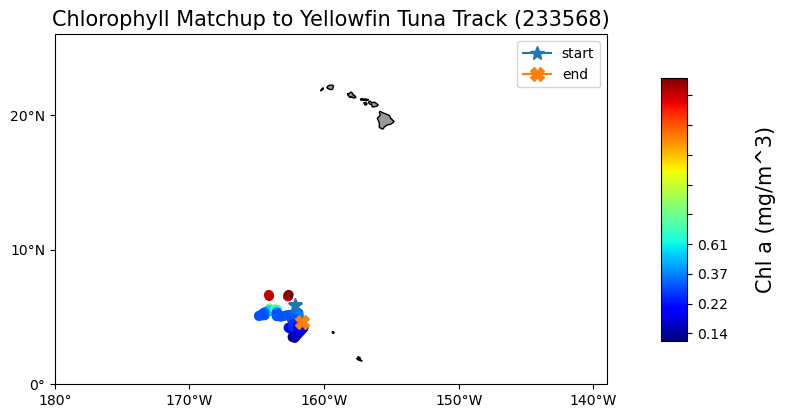

In [112]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:

# set the projection
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([180, 221, 0, 26], ccrs.PlateCarree())

# Set the tick marks to be slightly inside the map extents
ax1.set_xticks(range(180, 221, 10), crs=ccrs.PlateCarree())
ax1.set_yticks(range(0, 26, 10), crs=ccrs.PlateCarree())

# Add geographical features
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# build and plot coordinates onto map
x,y = list(df["Most Likely Longitude"]),list(df["Most Likely Latitude"])
ax1 = plt.scatter(x, y, transform=ccrs.PlateCarree(),
                  marker='o',
                  c=np.log(df.matched_chla),
                  cmap=plt.get_cmap('jet')
                  )
ax1=plt.plot(x[0],y[0],marker='*', label='start',transform=ccrs.PlateCarree(), markersize=10)
ax1=plt.plot(x[-1],y[-1],marker='X', label='end',transform=ccrs.PlateCarree(), markersize=10)



# control color bar values spacing
#levs2 = np.arange(-2.5, 0, 0.5)
#cbar=plt.colorbar(ticks=levs2, shrink=0.75, aspect=10)
cbar=plt.colorbar(shrink=0.75, aspect=10)
cbar.set_label("Chl a (mg/m^3)", size=15, labelpad=20)

# set the labels to be exp(levs2) so the label reflect values of chl-a, not log(chl-a)
cbar.ax.set_yticklabels(np.around(np.exp(levs2), 2), size=10)

plt.legend()
plt.title("Chlorophyll Matchup to Yellowfin Tuna Track (233568)", size=15)
plt.show()

## On your own!

##### Exercise 1:
Repeat the steps above with a different dataset.
For example, extract sea surface temperature data using the NOAA Geo-polar Blended Analysis SST, GHRSST dataset:
https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5NRT_Lon0360.html  
* This dataset is a different ERDDAP; It has a different base URL and dataset ID and variable name.
* Check the metadata to make sure the dataset covers the spatial and temporal range of the track dataset.   


##### Exercise 2:
Go to an ERDDAP of your choice, find a dataset of interest, generate the URL, copy it and edit the script above to run a match up on that dataset.
To find other ERDDAP servers, you can use this search engine:
http://erddap.com/  
* This dataset will likely be on a different base URL and dataset ID and variable name.
* Check the metadata to make sure the dataset covers the spatial and temporal range of the track dataset. 

##### Optional
Repeat the steps above with a daily version of the OC-CCI dataset to see how cloud cover can reduce the data you retrieve. 
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0.html
